In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, roc_auc_score, roc_curve,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression

import tensorflow as tf

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

plt.style.use("seaborn-v0_8-whitegrid")

In [2]:
train_path = "spam_train.csv"
test_path  = "spam_test.csv"
names_path = "variable_names.txt"

train = pd.read_csv(train_path)
test  = pd.read_csv(test_path)

print("Train shape:", train.shape)
print("Test shape :", test.shape)

train.head()

Train shape: (3001, 59)
Test shape : (1600, 58)


,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58
0,646,0.00,0.00,0.00,0.0,0.00,0.045,4.08,0.00,0.036,...,0.000,0.00,0.000,0.421,0.126,0.000,4.181,26,46,1
1,3365,0.00,0.00,0.00,0.0,0.00,0.000,0.00,0.00,0.036,...,0.000,0.00,0.000,0.022,0.126,0.000,1.375,6,44,0
2,2992,0.00,0.00,0.00,0.0,0.00,0.224,0.00,0.00,0.036,...,0.377,0.00,0.094,0.000,0.126,0.000,4.807,31,274,0
3,3885,0.00,0.19,0.59,0.0,0.19,0.000,0.00,0.00,0.226,...,0.000,0.00,0.018,0.000,0.126,0.000,3.716,47,472,0
4,818,0.23,0.34,0.58,0.0,0.46,0.233,0.11,0.23,0.036,...,0.000,0.46,0.000,0.376,0.182,0.018,4.470,74,675,1


In [3]:
raw = open(names_path, "r", encoding="utf-8", errors="ignore").read()

# Extrae pares tipo: "1" "word\_freq\_make"
pairs = re.findall(r'\"(\d+)\"\s+\"([^\"]+)\"', raw)

def clean_name(s: str) -> str:
    s = s.replace("\\_", "_")
    s = s.replace("\\(", "(").replace("\\)", ")")
    s = s.replace("\\[", "[").replace("\\]", "]")
    s = s.replace("\\!", "!")
    s = s.replace("\\#", "#")
    s = s.replace("\\$", "$")
    s = s.replace("\\;", ";")
    return s

idx_to_name = {int(i): clean_name(n) for i, n in pairs}

# Renombrado V1..V58
rename_dict = {f"V{i}": idx_to_name[i] for i in range(1, 59) if i in idx_to_name}
train = train.rename(columns=rename_dict)
test  = test.rename(columns=rename_dict)

ID_COL  = "ID"
TARGET  = "SPAM"  # según el diccionario (variable 58) 
FEATURES = [idx_to_name[i] for i in range(1, 58)]  # 1..57

print("Target:", TARGET)
print("Número de features:", len(FEATURES))
print("Ejemplo features:", FEATURES[:8])

Target: SPAM
Número de features: 57
Ejemplo features: ['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d', 'word_freq_our', 'word_freq_over', 'word_freq_remove', 'word_freq_internet']


In [4]:
print("Distribución de clases (SPAM=1 / NO-SPAM=0):")
print(train[TARGET].value_counts(normalize=True))

desc = train[FEATURES].describe().T
desc.head(10)

Distribución de clases (SPAM=1 / NO-SPAM=0):
SPAM
0    0.598467
1    0.401533
Name: proportion, dtype: float64


,count,mean,std,min,25%,50%,75%,max
word_freq_make,3001.0,0.098570,0.339230,0.000,0.000,0.000,0.000,6.060
word_freq_address,3001.0,0.216348,1.300497,0.000,0.000,0.000,0.000,14.280
word_freq_all,3001.0,0.280920,0.497393,0.000,0.000,0.000,0.430,5.100
word_freq_3d,3001.0,0.088704,1.700779,0.000,0.000,0.000,0.000,42.810
word_freq_our,3001.0,0.322706,0.706823,0.000,0.000,0.000,0.400,10.000
word_freq_over,3001.0,0.150202,0.272827,0.000,0.000,0.054,0.192,3.609
word_freq_remove,3001.0,0.112929,0.377867,0.000,0.000,0.000,0.000,7.270
word_freq_internet,3001.0,0.111876,0.323354,0.000,0.000,0.000,0.000,4.340
word_freq_order,3001.0,0.161871,0.556893,0.036,0.036,0.036,0.036,9.126
word_freq_mail,3001.0,0.251036,0.698606,0.000,0.000,0.000,0.170,18.180


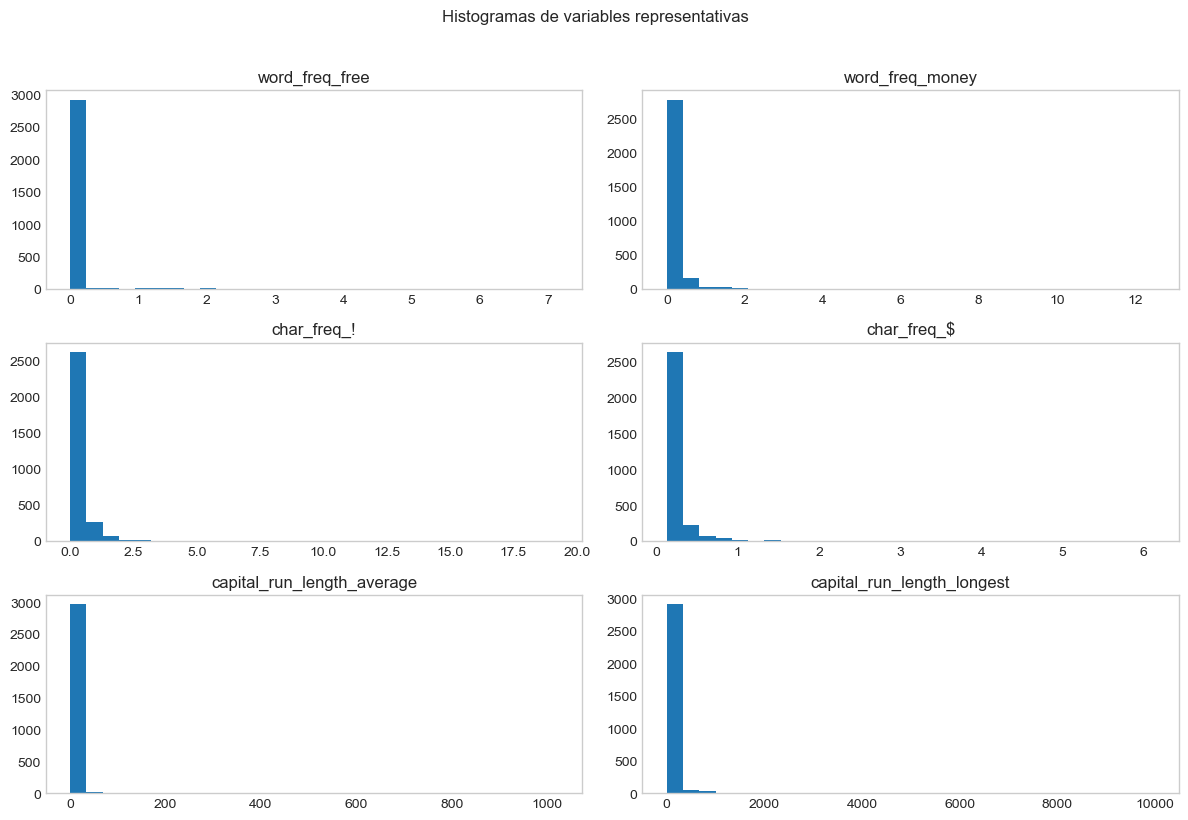

In [5]:
demo_features = [
    "word_freq_free", "word_freq_money",
    "char_freq_!", "char_freq_$",
    "capital_run_length_average", "capital_run_length_longest"
]
demo_features = [c for c in demo_features if c in train.columns]

train[demo_features].hist(bins=30, figsize=(12, 8), grid=False)
plt.suptitle("Histogramas de variables representativas", y=1.02)
plt.tight_layout()
plt.show()

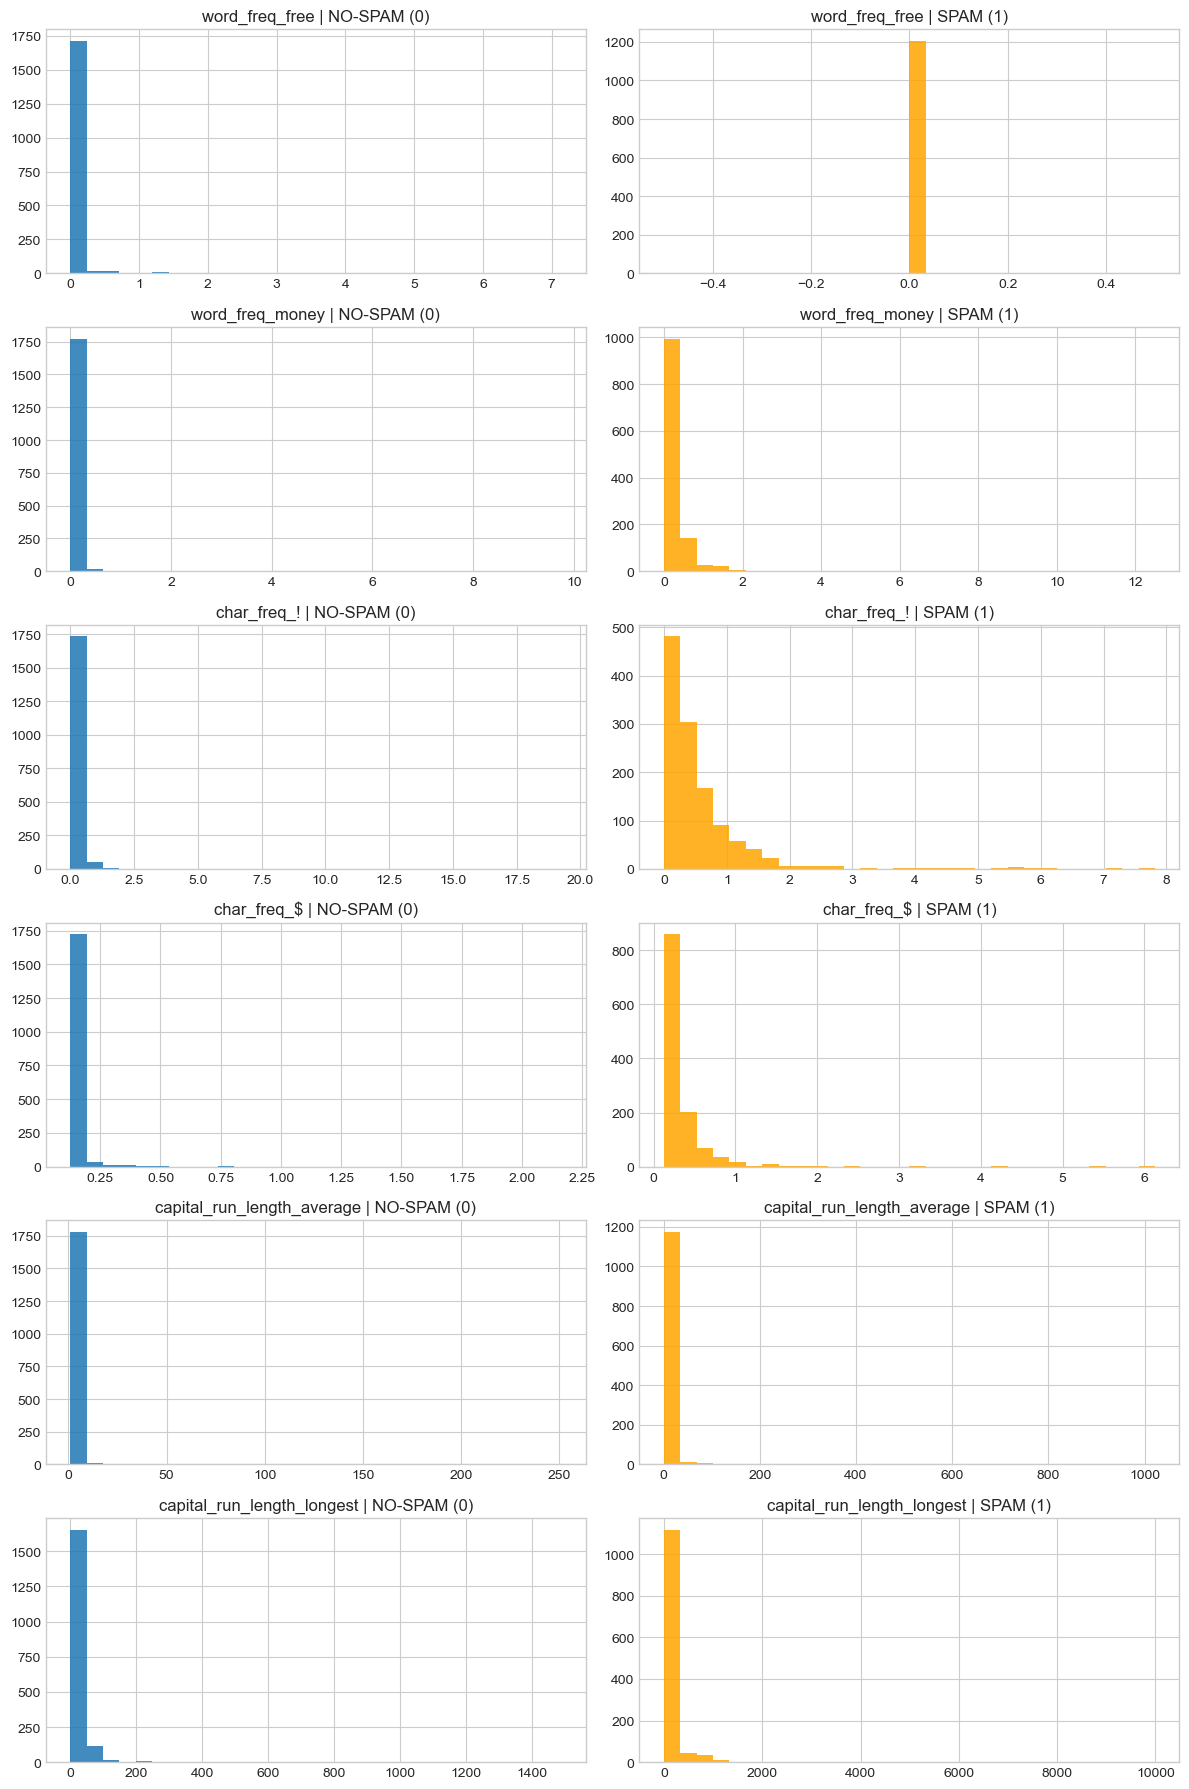

In [6]:
fig, axes = plt.subplots(len(demo_features), 2, figsize=(12, 3*len(demo_features)))
for i, col in enumerate(demo_features):
    axes[i, 0].hist(train.loc[train[TARGET]==0, col], bins=30, alpha=0.85)
    axes[i, 0].set_title(f"{col} | NO-SPAM (0)")
    axes[i, 1].hist(train.loc[train[TARGET]==1, col], bins=30, alpha=0.85, color="orange")
    axes[i, 1].set_title(f"{col} | SPAM (1)")
plt.tight_layout()
plt.show()

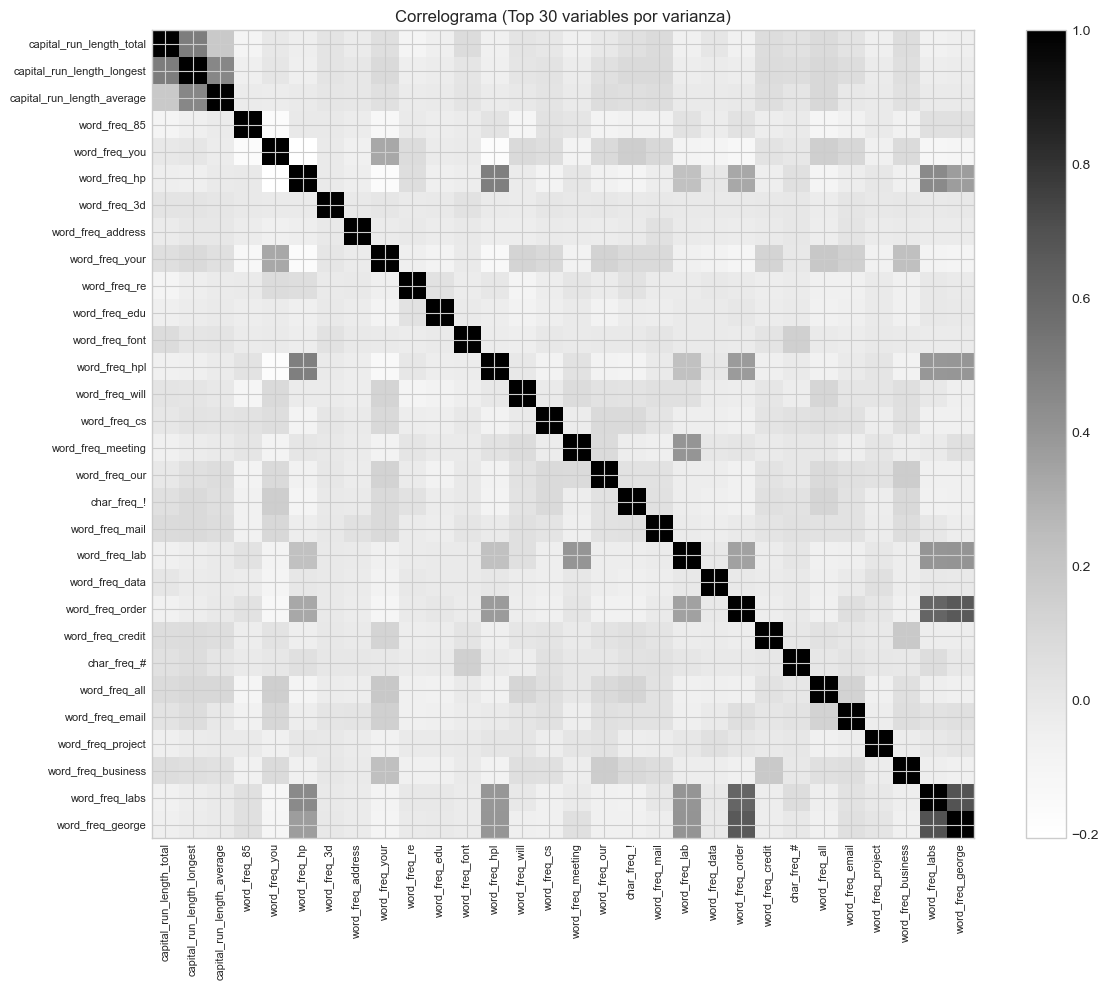

In [7]:
# Seleccionar top-k por varianza (para un heatmap legible)
k = 30
variances = train[FEATURES].var().sort_values(ascending=False)
top_cols = variances.head(k).index.tolist()

corr = train[top_cols].corr()

plt.figure(figsize=(12, 10))
plt.imshow(corr, aspect="auto", interpolation="nearest")
plt.colorbar()
plt.xticks(range(k), top_cols, rotation=90, fontsize=8)
plt.yticks(range(k), top_cols, fontsize=8)
plt.title("Correlograma (Top 30 variables por varianza)")
plt.tight_layout()
plt.show()

In [8]:
X = train[FEATURES].copy()
y = train[TARGET].astype(int).copy()

X_test = test[FEATURES].copy()

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

print("X_train_s:", X_train_s.shape, "X_val_s:", X_val_s.shape, "X_test_s:", X_test_s.shape)

X_train_s: (2400, 57) X_val_s: (601, 57) X_test_s: (1600, 57)


In [9]:
logreg = LogisticRegression(max_iter=2000, random_state=RANDOM_STATE)
logreg.fit(X_train_s, y_train)

va_proba_lr = logreg.predict_proba(X_val_s)[:, 1]
va_pred_lr  = (va_proba_lr >= 0.5).astype(int)

acc_lr = accuracy_score(y_val, va_pred_lr)
auc_lr = roc_auc_score(y_val, va_proba_lr)

print(f"[Baseline] Logistic Regression | Acc Val={acc_lr:.4f} | AUC Val={auc_lr:.4f}")

[Baseline] Logistic Regression | Acc Val=0.9334 | AUC Val=0.9778


In [17]:
# ===== 0) Imports & semillas =====
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_curve

SEED = 42
np.random.seed(SEED)
tf.keras.utils.set_random_seed(SEED)

# ===== 1) Utilidades =====
def best_threshold_by_accuracy(y_true, proba, step=0.001):
    thr = np.arange(0.0, 1.0, step)
    acc = [accuracy_score(y_true, (proba >= t).astype(int)) for t in thr]
    i = int(np.argmax(acc))
    return float(thr[i]), float(acc[i])

def _to_numpy_binary(y):
    if hasattr(y, "values"):
        y = y.values
    y = np.asarray(y).reshape(-1)
    return (y > 0.5).astype(np.int32)

def _safe_auc(y_true, y_prob):
    try:
        return float(roc_auc_score(y_true, y_prob))
    except Exception:
        return float("nan")

# ===== 2) MLP + Trainer (Opción A) =====
def build_mlp(input_dim, hidden1=64, hidden2=32, dropout=0.0, l2=0.0):
    """MLP sencillo para tabular (asume X ya escalada)."""
    reg = tf.keras.regularizers.l2(l2) if l2 > 0 else None
    return tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_dim,)),
        tf.keras.layers.Dense(hidden1, activation="relu", kernel_regularizer=reg),
        tf.keras.layers.Dropout(dropout) if dropout > 0 else tf.keras.layers.Lambda(lambda x: x),
        tf.keras.layers.Dense(hidden2, activation="relu", kernel_regularizer=reg),
        tf.keras.layers.Dropout(dropout) if dropout > 0 else tf.keras.layers.Lambda(lambda x: x),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ])

def train_batch_gd(
    model, Xtr, ytr, Xva, yva,
    lr=1e-3, epochs=300, patience=25, batch_size=128, verbose_every=10, seed=42
):
    """
    Entrenamiento mini-batch con GradientTape + Adam (sin escalado interno).
    Early stopping por AUC de validación. Restaura mejores pesos.
    """
    tf.keras.utils.set_random_seed(seed)
    ytr = _to_numpy_binary(ytr)
    yva = _to_numpy_binary(yva)

    train_ds = tf.data.Dataset.from_tensor_slices(
        (Xtr.astype(np.float32), ytr.astype(np.float32))
    ).shuffle(buffer_size=len(ytr), seed=seed, reshuffle_each_iteration=True
    ).batch(batch_size)

    Xva_tf = tf.constant(Xva.astype(np.float32))
    bce = tf.keras.losses.BinaryCrossentropy()
    opt = tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=1.0)

    history = {"loss": [], "val_auc": [], "val_acc": [], "train_auc": [], "train_acc": []}
    best_auc, best_weights, wait = -np.inf, None, 0

    @tf.function
    def train_step(xb, yb):
        with tf.GradientTape() as tape:
            yhat = model(xb, training=True)
            loss = bce(tf.reshape(yb, (-1, 1)), yhat)
        grads = tape.gradient(loss, model.trainable_variables)
        grads_vars = [(g, v) for g, v in zip(grads, model.trainable_variables) if g is not None]
        opt.apply_gradients(grads_vars)
        return loss

    for epoch in range(1, epochs + 1):
        # loop de entrenamiento
        batch_losses = []
        for xb, yb in train_ds:
            loss = train_step(xb, yb)
            batch_losses.append(float(loss.numpy()))
        loss_epoch = float(np.mean(batch_losses)) if batch_losses else np.nan

        # métricas
        tr_proba = model(tf.constant(Xtr.astype(np.float32)), training=False).numpy().ravel()
        va_proba = model(Xva_tf, training=False).numpy().ravel()

        tr_pred = (tr_proba >= 0.5).astype(np.int32)
        va_pred = (va_proba >= 0.5).astype(np.int32)

        tr_acc = accuracy_score(ytr, tr_pred)
        va_acc = accuracy_score(yva, va_pred)
        tr_auc = _safe_auc(ytr, tr_proba)
        va_auc = _safe_auc(yva, va_proba)

        history["loss"].append(loss_epoch)
        history["val_auc"].append(va_auc)
        history["val_acc"].append(va_acc)
        history["train_auc"].append(tr_auc)
        history["train_acc"].append(tr_acc)

        if epoch == 1 or epoch % verbose_every == 0:
            print(f"Epoch {epoch:03d} | Loss={loss_epoch:.4f} | "
                  f"Acc Tr={tr_acc:.4f} Va={va_acc:.4f} | AUC Tr={tr_auc:.4f} Va={va_auc:.4f}")

        if (not np.isnan(va_auc)) and (va_auc > best_auc + 1e-4):
            best_auc = va_auc
            best_weights = model.get_weights()
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping en epoch {epoch} | Mejor AUC Val={best_auc:.4f}")
                break

    if best_weights is not None:
        model.set_weights(best_weights)

    return model, history

# ===== 3) Split -> Fit scaler SOLO en train -> Transform (sin fuga) =====
# Asegúrate de que train, FEATURES, TARGET existen en el entorno
X = train[FEATURES].values
y = train[TARGET].astype(int).values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, stratify=y, random_state=SEED)

scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train).astype("float32")
X_val_s   = scaler.transform(X_val).astype("float32")

print("Shapes (train/val):", X_train_s.shape, X_val_s.shape)

# ===== 4) GRID SEARCH (tu espacio; puedes ampliarlo) =====
search_space = [
    {"h1": 64, "h2": 32, "lr": 0.01,  "drop": 0.0, "l2": 0.0},
    {"h1": 32, "h2": 16, "lr": 0.01,  "drop": 0.0, "l2": 0.0},
    {"h1": 64, "h2": 32, "lr": 0.005, "drop": 0.1, "l2": 1e-4},
]

best = {"auc": -np.inf, "acc_thr": -np.inf, "cfg": None, "model": None, "history": None, "thr_opt": 0.5}

for cfg in search_space:
    print("\n=== Probando configuración:", cfg, "===")
    m = build_mlp(
        X_train_s.shape[1],
        hidden1=cfg["h1"], hidden2=cfg["h2"],
        dropout=cfg.get("drop", 0.0), l2=cfg.get("l2", 0.0)
    )
    m, hist = train_batch_gd(
        m, X_train_s, y_train, X_val_s, y_val,
        lr=cfg["lr"], epochs=300, patience=25, verbose_every=20, seed=SEED
    )

    # Evaluación en validación (AUC + accuracy al mejor umbral)
    va_proba = m(tf.constant(X_val_s, dtype=tf.float32), training=False).numpy().ravel()
    va_auc   = roc_auc_score(y_val, va_proba)
    thr_opt, acc_opt = best_threshold_by_accuracy(y_val, va_proba, step=0.001)

    print(f"AUC Val (final): {va_auc:.4f}")
    print(f"Accuracy Val @ thr*={thr_opt:.3f}: {acc_opt:.4f}")

    # Criterio: AUC principal; si empata AUC, decide por Acc@thr*
    if (va_auc > best["auc"]) or (np.isclose(va_auc, best["auc"], atol=1e-4) and acc_opt > best["acc_thr"]):
        best.update({"auc": va_auc, "acc_thr": acc_opt, "cfg": cfg, "model": m, "history": hist, "thr_opt": thr_opt})

print("\n🏆 Mejor configuración:", best["cfg"], "| AUC Val:", best["auc"], "| Acc@thr*:", best["acc_thr"], "| thr*:", best["thr_opt"])
best_model   = best["model"]
best_history = best["history"]

Shapes (train/val): (2400, 57) (601, 57)

=== Probando configuración: {'h1': 64, 'h2': 32, 'lr': 0.01, 'drop': 0.0, 'l2': 0.0} ===

Epoch 001 | Loss=0.3247 | Acc Tr=0.9296 Va=0.9218 | AUC Tr=0.9734 Va=0.9673
Epoch 020 | Loss=0.0316 | Acc Tr=0.9875 Va=0.9384 | AUC Tr=0.9995 Va=0.9781
Early stopping en epoch 33 | Mejor AUC Val=0.9847
AUC Val (final): 0.9847
Accuracy Val @ thr*=0.694: 0.9468

=== Probando configuración: {'h1': 32, 'h2': 16, 'lr': 0.01, 'drop': 0.0, 'l2': 0.0} ===
Epoch 001 | Loss=0.3861 | Acc Tr=0.9146 Va=0.9135 | AUC Tr=0.9643 Va=0.9582
Epoch 020 | Loss=0.0441 | Acc Tr=0.9933 Va=0.9334 | AUC Tr=0.9993 Va=0.9768
Early stopping en epoch 33 | Mejor AUC Val=0.9845
AUC Val (final): 0.9845
Accuracy Val @ thr*=0.482: 0.9468

=== Probando configuración: {'h1': 64, 'h2': 32, 'lr': 0.005, 'drop': 0.1, 'l2': 0.0001} ===
Epoch 001 | Loss=0.3951 | Acc Tr=0.9137 Va=0.8985 | AUC Tr=0.9607 Va=0.9512
Epoch 020 | Loss=0.0769 | Acc Tr=0.9812 Va=0.9451 | AUC Tr=0.9980 Va=0.9845
Epoch 040 | 

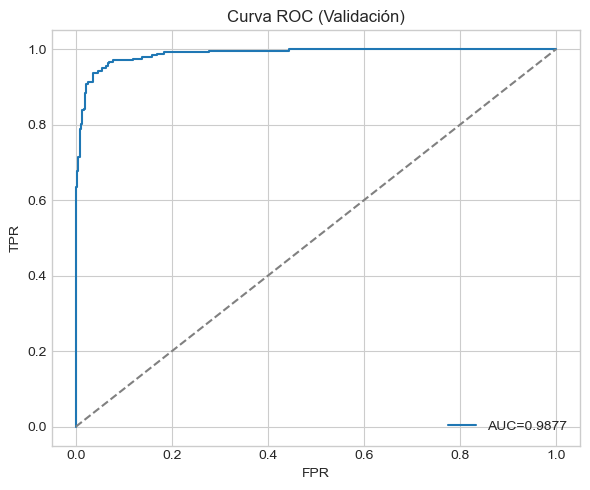

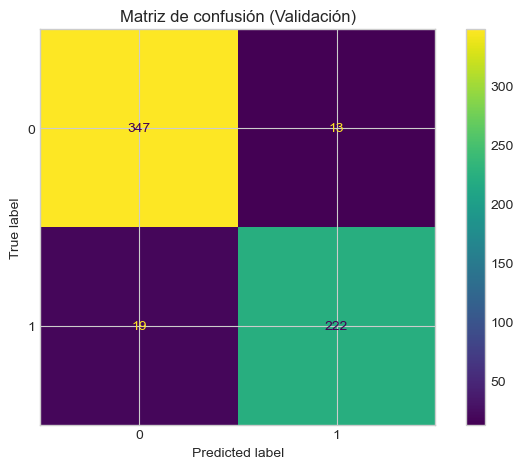

Accuracy Val: 0.9467554076539102
AUC Val: 0.9876901798063624


In [19]:
X_val_tf = tf.constant(X_val_s, dtype=tf.float32)
va_proba = best_model(X_val_tf, training=False).numpy().ravel()
va_pred  = (va_proba >= 0.5).astype(int)

# ROC
fpr, tpr, thr = roc_curve(y_val, va_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_val, va_proba):.4f}")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.title("Curva ROC (Validación)")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.tight_layout()
plt.show()

# Matriz de confusión
cm = confusion_matrix(y_val, va_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(values_format="d")
plt.title("Matriz de confusión (Validación)")
plt.tight_layout()
plt.show()

print("Accuracy Val:", accuracy_score(y_val, va_pred))
print("AUC Val:", roc_auc_score(y_val, va_proba))

In [21]:
# Re-escalar usando TODO el train
scaler_final = StandardScaler()
X_all_s = scaler_final.fit_transform(train[FEATURES])
y_all   = train[TARGET].astype(int)

X_test_s_final = scaler_final.transform(test[FEATURES])

# Entrenar modelo final con mejor configuración encontrada
cfg = best["cfg"]
final_model = build_mlp(X_all_s.shape[1], hidden1=cfg["h1"], hidden2=cfg["h2"])

final_model, final_hist = train_batch_gd(
    final_model,
    X_all_s, y_all,
    X_val_s, y_val,            # (solo para early stopping; no afecta el test)
    lr=cfg["lr"],
    epochs=300,
    patience=25,
    verbose_every=25
)

# Predicción en test
X_test_tf = tf.constant(X_test_s_final, dtype=tf.float32)
test_proba = final_model(X_test_tf, training=False).numpy().ravel()
y_test_pred = (test_proba >= 0.5).astype(int)

# Submission con columnas ID y pred (como te piden)
submission = pd.DataFrame({
    "ID": test[ID_COL],
    "Label": y_test_pred
})
submission.to_csv("submission1.csv", index=False)

print("✅ Guardado submission1.csv")
submission.head()

Epoch 001 | Loss=0.3451 | Acc Tr=0.9247 Va=0.9268 | AUC Tr=0.9693 Va=0.9692
Epoch 025 | Loss=0.0405 | Acc Tr=0.9890 Va=0.9900 | AUC Tr=0.9996 Va=0.9997
Epoch 050 | Loss=0.0099 | Acc Tr=0.9983 Va=1.0000 | AUC Tr=1.0000 Va=1.0000
Early stopping en epoch 56 | Mejor AUC Val=0.9999
✅ Guardado submission1.csv


,ID,Label
0,1147,1
1,2299,0
2,2839,1
3,52,1
4,4507,0
